In [1]:
# Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

Next we are going to run feature selection. We already found many features correlated. Now in each pair of highly-correlated features, we are going to drop the one with lower feature importance in a baseline random forest model.

In [2]:
# Read Data
df = pd.read_excel('../data/Wind_data_copy.xlsx', sheet_name='Train')

In [3]:
# The two features with missing values. Given they are highly correlated (i.e. > 95%) with other features without any missing value, we are going to directly drop them.
vars_missing = ['WS_1461024', 'WS_1571308']

In [4]:
# Create X and y
X = df.drop(columns=['DATETIME', 'CF'] + vars_missing) # Independent variables
y = df['CF'] # Target variable

In [5]:
# Calculate Pairwise Correlation and transform into long format
corr_matrix = X.corr().abs()
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']
corr_pairs = corr_pairs[corr_pairs['Var1'] != corr_pairs['Var2']]  # Remove self-correlation
corr_pairs = corr_pairs.apply(lambda x: pd.concat([pd.Series(sorted([x['Var1'], x['Var2']])), pd.Series(x['Correlation'])], ignore_index=True), axis=1) # Sort the variable names within each pair to ensure consistency
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']

In [6]:
# Filter pairs by correlation threshold (e.g., 80%)
corr_threshold = 0.8
high_corr_pairs = corr_pairs[corr_pairs['Correlation'] > corr_threshold]
high_corr_pairs.shape

(2550, 3)

In [7]:
# Remove duplicate pairs
high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Var1', 'Var2'])
high_corr_pairs.shape

(1275, 3)

In [8]:
# Calculate Feature Importance using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.head()

WS_1133733    0.006529
WS_1156770    0.002338
WS_1156968    0.003108
WS_1182195    0.001571
WS_1193865    0.003478
dtype: float64

In [9]:
# Identify Variables to Drop Within Each Pair of Highly Correlated Features
drop_vars = []
for _, row in high_corr_pairs.iterrows():
    if feature_importances[row['Var1']] > feature_importances[row['Var2']]:
        drop_vars.append(row['Var2'])
    else:
        drop_vars.append(row['Var1'])
len(drop_vars)

1275

In [10]:
# Remove duplicates from drop_vars list
drop_vars = list(set(drop_vars))
len(drop_vars)

94

In [11]:
# The remaining variables are
X.drop(drop_vars, axis = 1).columns

Index(['WS_1156968', 'WS_1321569', 'WS_1324653', 'WS_1358699', 'WS_1504146',
       'WS_1625374', 'WS_1899876', 'WS_1911282', 'WS_1953863', 'WS_2113254',
       'WS_2385763', 'WS_2455069', 'WS_2460378', 'WS_2467589', 'WS_2503597',
       'WS_676403'],
      dtype='object')

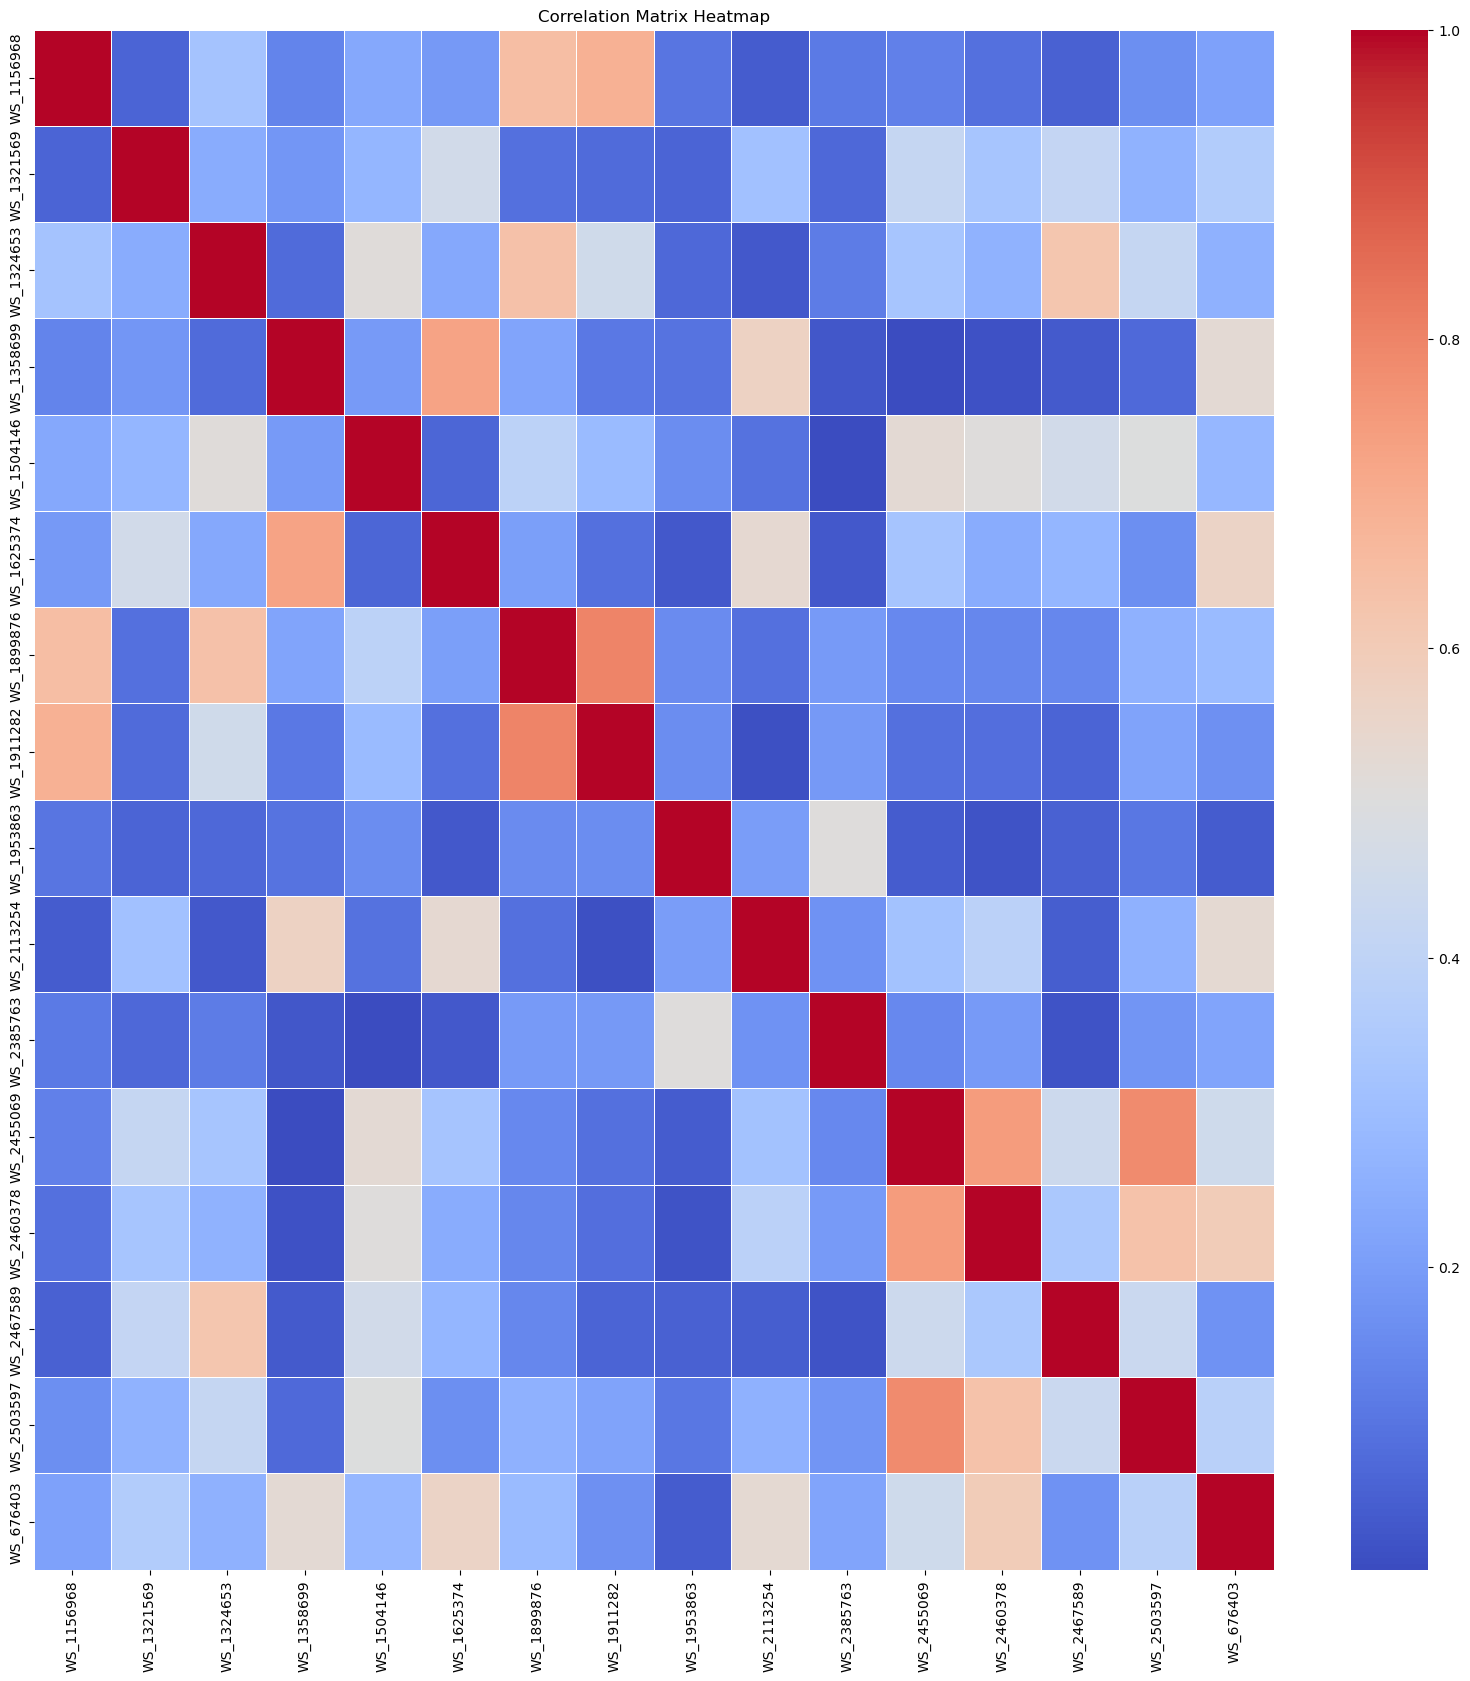

In [12]:
# Check correlation matrix again
corr_matrix_16 = X.drop(drop_vars, axis = 1).corr().abs()

# Plot the heatmap
plt.figure(figsize=(20, 20))  # You might need to adjust the size
sns.heatmap(corr_matrix_16, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Among the 16 remaining variables, there are some pairs with absolute correlation close to 0.8.

In [13]:
# Write the drop_vars list to a file for later use
with open('../data/drop_vars_list.txt', 'w') as file:
    for var in drop_vars:
        file.write("%s\n" % var)